# AlexNet

在2012年之前，计算机视觉领域长期依赖手工设计特征（如SIFT、HOG）和传统机器学习模型（如SVM），这些方法在复杂任务（如大规模图像分类）上性能有限。随着ImageNet数据集的发布（包含百万级标注图像），传统方法的瓶颈愈发明显——模型难以从海量数据中自动学习高阶特征。AlexNet在2012年ImageNet图像分类竞赛（ILSVRC）中以15.3%的Top-5错误率夺冠，远超第二名（26.2%），首次证明了深度卷积神经网络（CNN）在大规模视觉任务中的统治力，成为深度学习革命的里程碑。

核心创新点：

* ReLU激活函数：取代传统的Sigmoid/Tanh，缓解梯度消失问题，加速训练收敛。
* GPU并行训练：首次利用双GPU（GTX 580）并行计算，突破算力限制，推动硬件与深度学习的结合。
* Dropout正则化：在全连接层随机丢弃神经元，减少过拟合，提升泛化能力。
* 数据增强：通过裁剪、翻转、颜色扰动扩充数据，降低对训练数据的依赖。
* 局部响应归一化（LRN）：增强特征间竞争，后被批量归一化（BatchNorm）取代，但启发了归一化层设计。
* 重叠池化（Overlapping Pooling）：提升特征提取的丰富性，这一操作已经被non-overlapping pooling取代。
* 架构模板化：确立“卷积层→池化层→全连接层”的堆叠范式，后续模型（VGG、ResNet等）均沿袭此框架。
* 大数据驱动：证明数据规模与模型深度的正相关性，奠定“数据+算力+算法”的AI发展范式。

AlexNet不仅是技术突破，更是研究范式的转折点。它证明：通过数据与算力放大模型能力，AI可以解决此前被认为“不可能”的任务。其影响力远超计算机视觉，重塑了整个AI领域的发展轨迹，至今仍是深度学习课程与工业实践的“第一课”。

![alt text](resources/alex_architecture.png "Title")

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import time

from hdd.device.utils import get_device
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory, get_mean_and_std

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
DEVICE = get_device(["cuda", "cpu"])
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
print("Use device: ", DEVICE)

Use device:  cuda


## Imagenette数据集

AlexNet是在ImageNet上进行训练的，由于资源有限，我们在其子集上进行小规模尝试，[Imagenette](https://github.com/fastai/imagenette)是一个只包含10类的比较容易分类的小数据集。具体类别如下图所示：
![alt text](resources/imagenette_samples.png "Title")

In [2]:
# 计算Imagenette的均值方差，用如下代码
# train_dataest = ImagenetteInMemory(
#     root=DATA_ROOT,
#     split="train",
#     size="full",
#     download=True,
#     transform=transforms.Compose([transforms.ToTensor()]),
# )
# mean, std = get_mean_and_std(train_dataest)

# 我们跳过计算，直接给出结果
TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(296),
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)

BATCH_SIZE = 64
train_dataloader = torch.utils.data.DataLoader(
    ImagenetteInMemory(
        root=DATA_ROOT,
        split="train",
        size="full",
        download=True,
        transform=train_dataset_transforms,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
val_dataloader = torch.utils.data.DataLoader(
    ImagenetteInMemory(
        root=DATA_ROOT,
        split="val",
        size="full",
        download=True,
        transform=val_dataset_transforms,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)
print("Basic Info of train dataaset ", train_dataloader.dataset)
print("Basic Info of val dataset ", val_dataloader.dataset)

Basic Info of train dataaset  Dataset ImagenetteInMemory
    Number of datapoints: 9469
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    StandardTransform
Transform: Compose(
               Resize(size=296, interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4625, 0.458, 0.4295], std=[0.2452, 0.239, 0.2469])
           )
Basic Info of val dataset  Dataset ImagenetteInMemory
    Number of datapoints: 3925
    Root location: /home/tf/workspace/hands-dirty-on-dl/dataset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.4625, 0.458, 0.429

In [6]:
from hdd.models.cnn.alexnet import AlexNet
from hdd.train.early_stopping import EarlyStoppingInMem
from hdd.train.classification_utils import naive_train_classification_model

net = AlexNet(num_classes=10, dropout=0.5, add_norm_layer=True).to(DEVICE)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=15, gamma=0.5, last_epoch=-1
)
early_stopper = EarlyStoppingInMem(patience=15, verbose=False)
max_epochs = 150

train_statistics_with_norm = naive_train_classification_model(
    net,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    early_stopper,
)

Epoch: 1/150 Train Loss: 1.8784 Accuracy: 0.3371 Time: 3.94968  | Val Loss: 1.9061 Accuracy: 0.3918
Epoch: 2/150 Train Loss: 1.4719 Accuracy: 0.5052 Time: 4.12303  | Val Loss: 1.7843 Accuracy: 0.4339
Epoch: 3/150 Train Loss: 1.2993 Accuracy: 0.5743 Time: 3.95677  | Val Loss: 1.2857 Accuracy: 0.5758
Epoch: 4/150 Train Loss: 1.2208 Accuracy: 0.6015 Time: 3.83922  | Val Loss: 1.1351 Accuracy: 0.6387
Epoch: 5/150 Train Loss: 1.1542 Accuracy: 0.6259 Time: 4.14857  | Val Loss: 1.0331 Accuracy: 0.6637
Epoch: 6/150 Train Loss: 1.0872 Accuracy: 0.6475 Time: 4.15409  | Val Loss: 1.1059 Accuracy: 0.6507
Epoch: 7/150 Train Loss: 1.0429 Accuracy: 0.6624 Time: 4.21420  | Val Loss: 1.3344 Accuracy: 0.6043
Epoch: 8/150 Train Loss: 1.0189 Accuracy: 0.6702 Time: 3.95794  | Val Loss: 1.2044 Accuracy: 0.5926
Epoch: 9/150 Train Loss: 1.0210 Accuracy: 0.6653 Time: 4.14402  | Val Loss: 0.9504 Accuracy: 0.6904
Epoch: 10/150 Train Loss: 0.9500 Accuracy: 0.6950 Time: 3.85119  | Val Loss: 1.0097 Accuracy: 0.6841

In [9]:
# Train network without batch normalization
net_without_bn = AlexNet(num_classes=10, dropout=0.5, add_norm_layer=False).to(DEVICE)
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    net_without_bn.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-2
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=15, gamma=0.5, last_epoch=-1
)
early_stopper = EarlyStoppingInMem(patience=15, verbose=False)
max_epochs = 150

train_statistics_without_norm = naive_train_classification_model(
    net_without_bn,
    criteria,
    max_epochs,
    train_dataloader,
    val_dataloader,
    DEVICE,
    optimizer,
    scheduler,
    early_stopper,
    verbose=True,
)

Epoch: 1/150 Train Loss: 2.2915 Accuracy: 0.1213 Time: 4.78137  | Val Loss: 2.2627 Accuracy: 0.1906
Epoch: 2/150 Train Loss: 2.1807 Accuracy: 0.2061 Time: 3.96096  | Val Loss: 2.0810 Accuracy: 0.2341
Epoch: 3/150 Train Loss: 2.0718 Accuracy: 0.2369 Time: 4.00623  | Val Loss: 1.9818 Accuracy: 0.2915
Epoch: 4/150 Train Loss: 2.0194 Accuracy: 0.2749 Time: 3.91538  | Val Loss: 1.9361 Accuracy: 0.3225
Epoch: 5/150 Train Loss: 1.9847 Accuracy: 0.2950 Time: 3.95778  | Val Loss: 1.9256 Accuracy: 0.3389
Epoch: 6/150 Train Loss: 1.9684 Accuracy: 0.3007 Time: 4.02134  | Val Loss: 1.8865 Accuracy: 0.3531
Epoch: 7/150 Train Loss: 1.9282 Accuracy: 0.3141 Time: 3.90479  | Val Loss: 1.8888 Accuracy: 0.3299
Epoch: 8/150 Train Loss: 1.9041 Accuracy: 0.3241 Time: 3.85574  | Val Loss: 1.9081 Accuracy: 0.3149
Epoch: 9/150 Train Loss: 1.8809 Accuracy: 0.3364 Time: 3.88946  | Val Loss: 1.9499 Accuracy: 0.3121
Epoch: 10/150 Train Loss: 1.8002 Accuracy: 0.3695 Time: 3.88374  | Val Loss: 1.7838 Accuracy: 0.3738

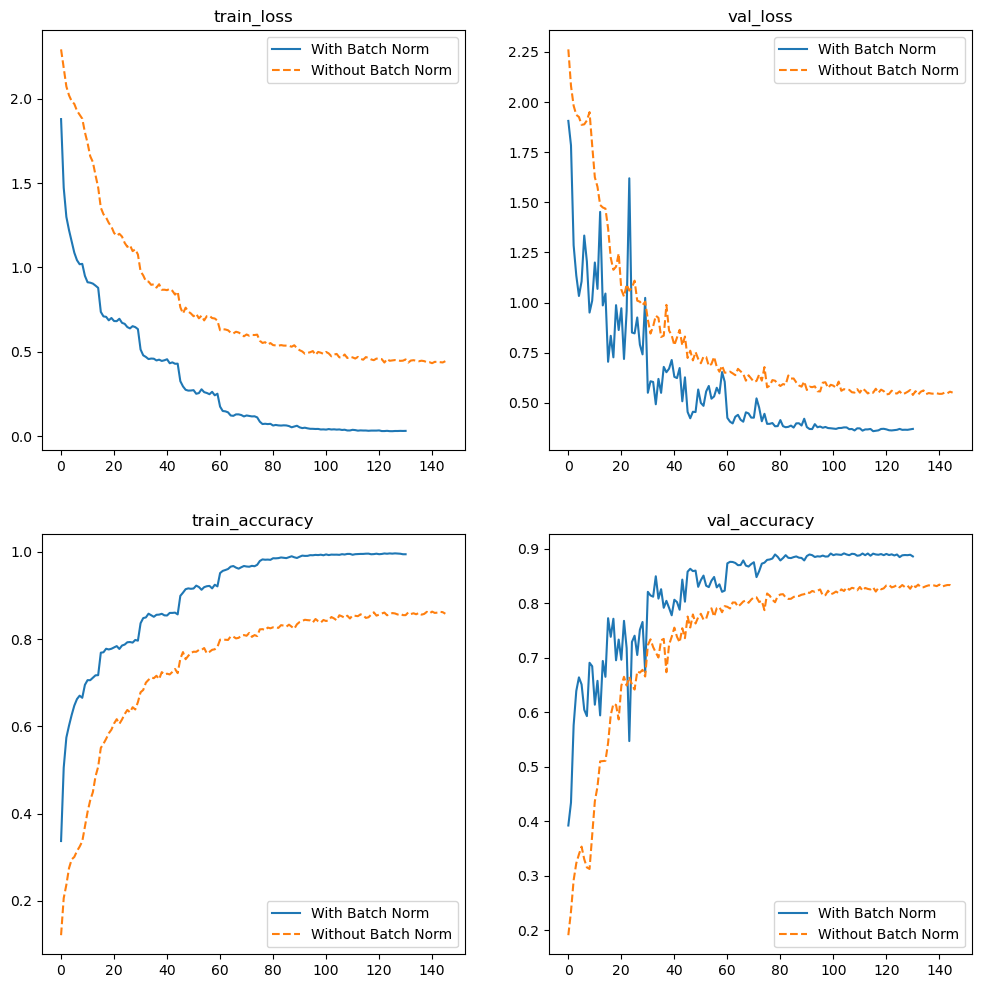

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = train_statistics_with_norm.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(train_statistics_with_norm[field], label="With Batch Norm", linestyle="-")
    plt.plot(train_statistics_without_norm[field], label="Without Batch Norm", linestyle="--")
    plt.legend()
    plt.title(field)

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import namedtuple
from hdd.train.classification_utils import eval_image_classifier

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)

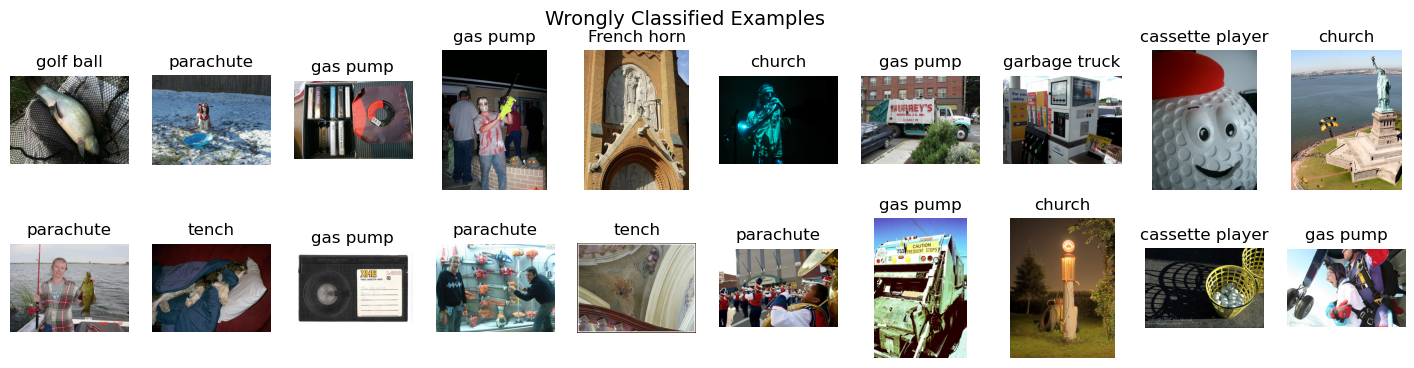

In [57]:
images_per_class = 2
per_class_image_count = defaultdict(int)
num_classes = 10
val_dataset = val_dataloader.dataset
fig, axes = plt.subplots(nrows=images_per_class, ncols=num_classes, figsize=(18, 4))
fig.suptitle("Wrongly Classified Examples", fontsize=14)
for sample in eval_result:
    idx = sample.idx
    predicted_label = sample.predicted_label
    gt_label = sample.gt_label
    if gt_label == predicted_label:
        continue
    i = per_class_image_count[gt_label]
    if i >= images_per_class:
        continue
    per_class_image_count[gt_label] += 1
    plt_idx = i * num_classes + gt_label + 1
    plt.subplot(images_per_class, num_classes, plt_idx)
    image = val_dataset._loaded_images[idx]
    plt.imshow(image)
    plt.axis("off")
    predicted_class_name = val_dataset.classes[predicted_label][0]
    plt.title(predicted_class_name)
gt_names = [c[0] for c in val_dataset.classes]
plt.show()

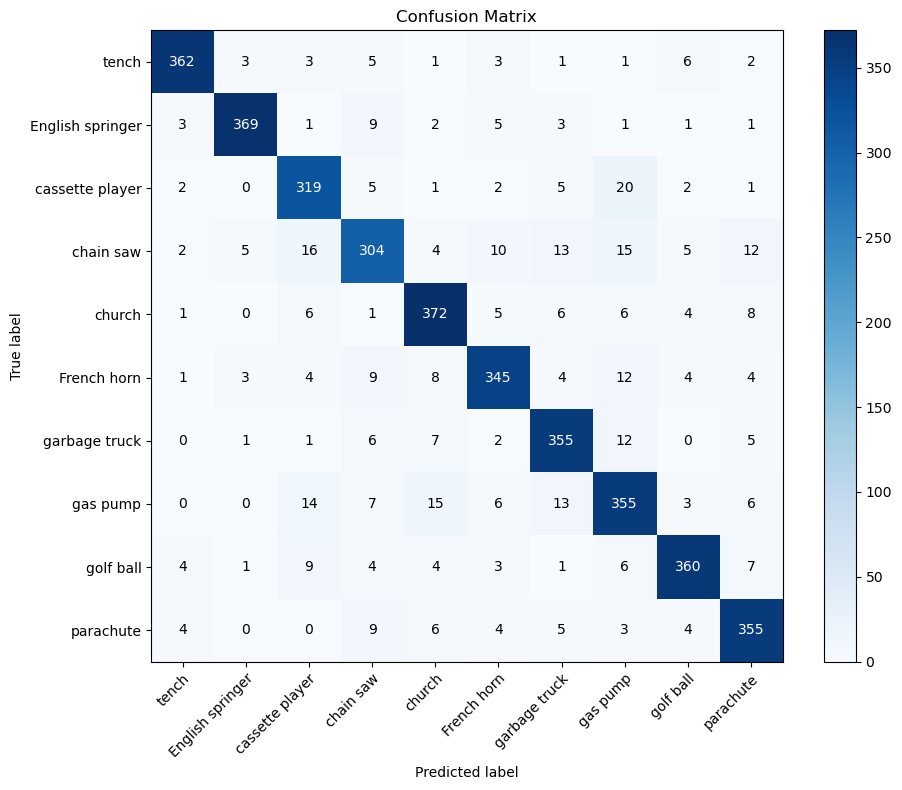

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix

all_gts = []
all_predictions = []
for item in eval_result:
    all_gts.append(item.gt_label)
    all_predictions.append(item.predicted_label)
cm = confusion_matrix(all_gts, all_predictions)

class_names = [
    "tench",
    "English springer",
    "cassette player",
    "chain saw",
    "church",
    "French horn",
    "garbage truck",
    "gas pump",
    "golf ball",
    "parachute",
]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=class_names,
    yticklabels=class_names,
    title="Confusion Matrix",
    ylabel="True label",
    xlabel="Predicted label",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            format(cm[i, j], "d"),
            ha="center",
            va="center",
            color="white" if cm[i, j] > thresh else "black",
        )

fig.tight_layout()
plt.show()

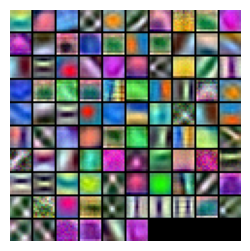

In [54]:
# 可视化网络的第一个卷积层的权重
from hdd.visualization.vis_utils import visualize_grid

W = net.features[0].conv2d.weight
W = W.detach().to("cpu").numpy()
W = W.transpose(0, 2, 3, 1)
plt.figure(figsize=(3, 3))
plt.imshow(visualize_grid(W, padding=1).astype("uint8"))
plt.gca().axis("off")
plt.show()